In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from collections import Counter
from argparse import Namespace
import json
import sys
import time
import getopt
import matplotlib.pyplot as plt

from sys import platform as _platform

if _platform == "win32":
    sys.path.insert(1, '..\..\\')
else:
    sys.path.insert(1, '../../')
from utils import fileutils

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, hidden_size):
        
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.gru = nn.GRU(embedding_size,
                            hidden_size,
                            batch_first=True)
        self.dense = nn.Linear(hidden_size, n_vocab)
    
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.gru(embed, prev_state)
        logits = self.dense(output)

        return logits, state
    
    def zero_state(self, batch_size):
#         print('zero_state called')
        return Variable(torch.zeros(1,batch_size,self.hidden_size))

In [13]:
device = None
epochs = 100
learning_rate = 0.01
for_units = True
weights, weights_units, weight_tensor = [], [], None
len_dict = {}

# options, remainder = getopt.getopt(sys.argv[1:], 'e:l:u')
# for opt, arg in options:
#     if opt in ('-e'):
#         try:
#             epochs = int(arg.strip())
#         except ValueError:
#             sys.exit('Epoch has to be a positive integer.')
#     elif opt in ('-l'):
#         try:
#             learning_rate = float(arg.strip())
#         except ValueError:
#             sys.exit('Learning Rate has to be a numeric value.')
#     elif opt in ('-u'):
#         for_units = True

epochs = 150
learning_rate = 0.01

In [4]:
def convert_dataframe_to_list(dataframe_obj):
    '''
    Method to return list of all the values in a single row separated by spaces from the dataframe.
    All values that were space separated before are converted to a single word.
    example. Sea Surface Temperature -> SeaSurfaceTemperature

    Parameters
    ----------
    dataframe_obj : pandas dataframe
        Dataframe contains the training data.

    Returns
    -------
    new_list : list
        List of input sentences.
    reference_dict : dict
        Mapping of the word to its space-stripped version used for training.

    '''
    reference_dict = {}
    
    dataframe_obj = dataframe_obj.replace(np.nan, 'NA', regex=True)
    lipd_data_list = dataframe_obj.values.tolist()

    new_list = []
    for lis in lipd_data_list:
        for val in lis:
            reference_dict[val] = val.replace(" ", "")
        lis = [val.replace(" ", "") for val in lis]
        lis = (',').join(lis)
        new_list.append(lis)

    return new_list, reference_dict

In [5]:
def calculate_unique_chains(dataframe_obj):

    global weights, weights_units

    chain1 = dataframe_obj[['archiveType', 'proxyObservationType','units']]
    
    chain2 = dataframe_obj.filter(['archiveType', 'proxyObservationType', 'interpretation/variable', 'interpretation/variableDetail', 
    'inferredVariable', 'inferredVarUnits'])
    

    chain1_list = chain1.values.tolist()

    for lis in chain1_list:
        lis = [val.replace(" ", "") for val in lis]
        lis = (',').join(lis)
        
        com_ind = lis.find(',', lis.index(','))
        while com_ind != -1:
            weights.append(lis[:com_ind])
            com_ind = lis.find(',', com_ind+1)
        weights_units.append(lis)

    chain2_list = chain2.values.tolist()
    for lis in chain2_list:
        lis = [val.replace(" ", "") for val in lis]
        lis = (',').join(lis)
        
        com_ind = lis.find(',', lis.index(','))
        while com_ind != -1:
            weights.append(lis[:com_ind])
            com_ind = lis.find(',', com_ind+1)
        weights.append(lis)

In [6]:
def get_data_from_df(lipd_data_df, batch_size, seq_size):
    '''
    Read training data into dataframe for training the model.
    The training data needs to be Label Encoded because pytorch only works with float data.
    Select only num_batches*seq_size*batch_size amount of data to work on.

    Parameters
    ----------
    lipd_data_df : pandas dataframe
        Dataframe containing either training sdata.
    batch_size : int
        Used to divide the training data into batches for training.
    seq_size : int
        Defines the sequence size for the training sentences.
    
    Returns
    -------
    int_to_vocab : dict
        Mapping of the Label Encoding int to text.
    vocab_to_int : dict
        Mapping of the Label Encoding text to int.
    n_vocab : int
        Size of the Label Encoding Dict.
    in_text : list
        Contains the input text for training.
    out_text : list
        Corresponding output for the input text.
    reference_dict : dict
        Mapping of the word to its space-stripped version used for training.

    '''
    global len_dict, weight_tensor

    calculate_unique_chains(lipd_data_df)

    if for_units:
        lipd_data = lipd_data_df.filter(['archiveType', 'proxyObservationType', 'units'])
    else:
        lipd_data = lipd_data_df.filter(['archiveType', 'proxyObservationType', 'interpretation/variable', 'interpretation/variableDetail', 'inferredVariable', 'inferredVarUnits'])
    new_list, reference_dict = convert_dataframe_to_list(lipd_data)
    
    token_list = (',').join(new_list)

    text = token_list.split(',')

    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))

    weights_counter = Counter(weights)
    weights_u_counter = Counter(weights_units)
    

    len_dict = {'1':[], '2':[], '3':[], '3_units':[], '4':[], '5':[], '6':[]}
    for k,v in weights_counter.items():
        k_l = k.split(',')
        len_dict[str(len(k_l))].append(k)
    
    for k,v in weights_u_counter.items():
        len_dict['3_units'].append(k)

    l =  {k:len(v) for k,v in len_dict.items()}
    print('list of len', l)

    weights_counter.update(weights_u_counter)
    print(len(weights_counter))
    total_count = sum(weights_counter.values())
    for k,v in weights_counter.items():
        weights_counter[k] = v/total_count

    weight_tensor = torch.FloatTensor(list(weights_counter.values())).cuda()

    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text, reference_dict

In [7]:
def get_batches(in_text, out_text, batch_size, seq_size):
    '''
    Returns a batch each for the input sequence and the expected output word.

    Parameters
    ----------
    in_text : list
        Label Encoded strings of text.
    out_text : list
        Label Encoded Output for each each input sequence.
    batch_size : int
        Parameter to signify the size of each batch.
    seq_size : int
        Parameter to signify length of each sequence. In our case we are considering 2 chains, one of length 3 and the other of length 6.

    Yields
    ------
    list
        batch of input text sequence each of seq_size.
    list
        batch of output text corresponding to each input.

    '''
    
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    # Increment the loop by seq_size, because we have unique sequence and not a continuation.
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

In [8]:
def get_loss_and_train_op(net, lr=0.01):
    '''
    We are using CrossEntropy as a Loss Function for this RNN Model since this is a Multi-class classification kind of problem.
    

    Parameters
    ----------
    net : neural network instance
        Loss function is set for the Neural Network.
    lr : float, optional
        Defines the learning rate for the neural network. The default is 0.001.

    Returns
    -------
    criterion : Loss function instance
        Loss Function instance for the neural network.
    optimizer : Optimizing function instance
        Optimizer used for the neural network.

    '''
    criterion = nn.CrossEntropyLoss(weight = None)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    return criterion, optimizer

In [9]:
def print_save_loss_curve(train_loss_list, chain):
    '''
    Method to save the plot for the training loss curve.

    Parameters
    ----------
    loss_value_list : list
        List with the training loss values.
    chain : str
        To differentiate between the proxyObservationTypeUnits chain from the proxyObservationType & interpretation/variable chain.

    Returns
    -------
    None.

    '''
    
    plt.plot(train_loss_list, label='Train Loss')
        
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend(loc='best')
    fig = plt.gcf()
    if not sys.stdin.isatty():    
        plt.show()
        
    timestr = time.strftime("%Y%m%d_%H%M%S")    
    final_path = loss_curve_path + chain + '_gru_training_loss_e_' + str(epochs) + '_l_'+ str(learning_rate) + '_' + timestr + '.png'
    print('\nSaving the plot at ', final_path)
    fig.savefig(final_path, bbox_inches='tight')
    plt.close()

In [10]:
def train_RNN(train_label_dict, seq_size):
    '''
    Method to train a gru model on in_text and out_text.
    This method will save the model for the last epoch.

    Parameters
    ----------
    train_label_dict : dict
        Contains training information like the encoded input sequence, encoded output sequence information and number of words for training and validation data.
    seq_size : int
        Parameter to signify length of each sequence. In our case we are considering 2 chains, one of length 3 and the other of length 6.

    Returns
    -------
    None.

    '''
    in_text = train_label_dict['in_text']
    out_text = train_label_dict['out_text']
    n_vocab = train_label_dict['n_vocab']
    
    net = RNNModule(n_vocab, seq_size,
                    flags.embedding_size, flags.hidden_size)
    net = net.to(device)

    criterion, optimizer = get_loss_and_train_op(net, learning_rate)

    iteration = 0
    train_loss_list = []
    
    if for_units:
        print('\nTraining Data for the chain archiveType -> proxyObservationType -> proxyObservationTypeUnits\n')
    else:
        print('\nTraining Data for the chain archiveType -> proxyObservationType -> interpretation/variable -> interpretation/variableDetail -> inferredVariable -> inferredVarUnits\n')
        
    for e in range(epochs):

        # TRAIN PHASE
        batches = get_batches(in_text, out_text, flags.batch_size, seq_size)
        state_h = net.zero_state(flags.batch_size)
        
        # Transfer data to GPU
        state_h = state_h.to(device)
        
        train_loss = 0
        iteration = 0
        for x, y in batches:
            iteration += 1
            
            # Tell it we are in training mode
            net.train()

            # Reset all gradients
            optimizer.zero_grad()
            
            x = torch.tensor(x).to(device).long()
            y = torch.tensor(y).to(device).long()

            logits, (state_h) = net(x, state_h)
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()

            train_loss += loss.item()
            
            # Perform back-propagation
            loss.backward()
            
            _ = torch.nn.utils.clip_grad_norm_(
                net.parameters(), flags.gradients_norm)

            # Update the network's parameters
            optimizer.step()
        
        train_loss_list.append(train_loss/iteration)

        print('Epoch: {}/{}'.format(e, epochs),
                'Training Loss: {}'.format(train_loss_list[-1]))  

    timestr = time.strftime("%Y%m%d_%H%M%S")    
    if for_units:
        print('\nSaving the model file...')
        torch.save(net.state_dict(),model_file_path + 'model_gru_units_'+timestr+'.pth')
    else:
        print('\nSaving the model file...')
        torch.save(net.state_dict(),model_file_path + 'model_gru_interp_'+timestr+'.pth')
    
    print_save_loss_curve(train_loss_list, 'proxy_units_' if for_units else 'proxy_interp_')
    print(net)

In [11]:
def main():
    
    global int_to_vocab, vocab_to_int, n_vocab, in_text, out_text, device
    global int_to_vocab_u, vocab_to_int_u, n_vocab_u, in_text_u, out_text_u
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    timestr = time.strftime("%Y%m%d_%H%M%S")
    
    train_df = pd.read_csv(flags.train_file)
    train_df = train_df.replace(np.nan, 'NA', regex=True)

    if not for_units:
        int_to_vocab, vocab_to_int, n_vocab, in_text, out_text, reference_dict = get_data_from_df(
            train_df, flags.batch_size, flags.seq_size)
        
        model_tokens = {'model_tokens' : int_to_vocab, 'reference_dict': reference_dict, 'len_dict' : {k:len(v) for k,v in len_dict.items()}}
        with open(model_file_path+'model_token_info_'+timestr+'.txt', 'w') as json_file:
            json.dump(model_tokens, json_file)

        train_label_dict = {'n_vocab' : n_vocab, 'in_text' : in_text, 'out_text' : out_text}
        # Train for archive -> proxyObservationType -> interpretation/variable -> interpretation/variableDetail -> inferredVariable -> inferredVarUnits
        train_RNN(train_label_dict, flags.seq_size)
    else:
        int_to_vocab_u, vocab_to_int_u, n_vocab_u, in_text_u, out_text_u, reference_dict_u = get_data_from_df(
            train_df, flags.batch_size, flags.seq_size_u)
        
        model_tokens = {'model_tokens_u' : int_to_vocab_u, 'reference_dict_u' : reference_dict_u, 'len_dict' : {k:len(v) for k,v in len_dict.items()}}
        
        with open(model_file_path+'model_token_units_info_'+timestr+'.txt', 'w') as json_file:
            json.dump(model_tokens, json_file)
        train_label_dict = {'n_vocab' : n_vocab_u, 'in_text' : in_text_u, 'out_text' : out_text_u}
        # Train for archive -> proxyObservationType -> units
        train_RNN(train_label_dict, flags.seq_size_u)
    
    

list of len {'1': 14, '2': 112, '3': 147, '3_units': 160, '4': 243, '5': 459, '6': 465}
1563

Training Data for the chain archiveType -> proxyObservationType -> interpretation/variable -> interpretation/variableDetail -> inferredVariable -> inferredVarUnits

Epoch: 0/150 Training Loss: 1.1902371436050259
Epoch: 1/150 Training Loss: 0.8450263150778833
Epoch: 2/150 Training Loss: 0.8207915245052875
Epoch: 3/150 Training Loss: 0.8119374765563256
Epoch: 4/150 Training Loss: 0.804991803013582
Epoch: 5/150 Training Loss: 0.802823967745214
Epoch: 6/150 Training Loss: 0.7986696706604712
Epoch: 7/150 Training Loss: 0.7968292369465648
Epoch: 8/150 Training Loss: 0.7964726418154346
Epoch: 9/150 Training Loss: 0.7951918908001221
Epoch: 10/150 Training Loss: 0.7998132722074633
Epoch: 11/150 Training Loss: 0.7991607889686663
Epoch: 12/150 Training Loss: 0.796158707633461
Epoch: 13/150 Training Loss: 0.7954514456778458
Epoch: 14/150 Training Loss: 0.7974489466431215
Epoch: 15/150 Training Loss: 0.794

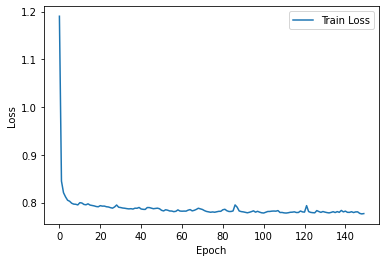


Saving the plot at  ..\..\data\loss\proxy_interp__gru_training_loss_e_150_l_0.01_20210505_165449.png
RNNModule(
  (embedding): Embedding(242, 48)
  (gru): GRU(48, 48, batch_first=True)
  (dense): Linear(in_features=48, out_features=242, bias=True)
)


In [12]:
if _platform == "win32":
    data_file_dir = '..\..\data\csv\\'
    model_file_path = '..\..\data\model_gru\\' 
    loss_curve_path = '..\..\data\loss\\'
else:
    data_file_dir = '../../data/csv/'
    model_file_path = '../../data/model_gru/'
    loss_curve_path = '../../data/loss/'

train_path = fileutils.get_latest_file_with_path(data_file_dir, 'lipdverse_downsampled_*.csv')

flags = Namespace(
    train_file = train_path,
    seq_size_u=3,
    seq_size=6,
    batch_size=48,
    embedding_size=48,
    hidden_size=48,
    gradients_norm=5,
    initial_words=['MarineSediment'],
    predict_top_k=5,
    checkpoint_path=model_file_path,
)

new_list = []
reference_dict = {}
int_to_vocab = {}
vocab_to_int = {}
n_vocab_u = 0

if __name__ == '__main__':
    main()

list of len {'1': 14, '2': 112, '3': 147, '3_units': 160, '4': 243, '5': 459, '6': 465}
1563

Training Data for the chain archiveType -> proxyObservationType -> proxyObservationTypeUnits

Epoch: 0/150 Training Loss: 1.5252051754915428
Epoch: 1/150 Training Loss: 1.3548449470415147
Epoch: 2/150 Training Loss: 1.349139304095527
Epoch: 3/150 Training Loss: 1.3462631219031476
Epoch: 4/150 Training Loss: 1.3431905180318249
Epoch: 5/150 Training Loss: 1.3421838861150839
Epoch: 6/150 Training Loss: 1.340576050617441
Epoch: 7/150 Training Loss: 1.3396003860788248
Epoch: 8/150 Training Loss: 1.338560393585782
Epoch: 9/150 Training Loss: 1.335728787474616
Epoch: 10/150 Training Loss: 1.3343024294810606
Epoch: 11/150 Training Loss: 1.332065116908542
Epoch: 12/150 Training Loss: 1.3304102334779562
Epoch: 13/150 Training Loss: 1.3283537409149904
Epoch: 14/150 Training Loss: 1.326468889246282
Epoch: 15/150 Training Loss: 1.327842214672836
Epoch: 16/150 Training Loss: 1.3261798509617442
Epoch: 17/150

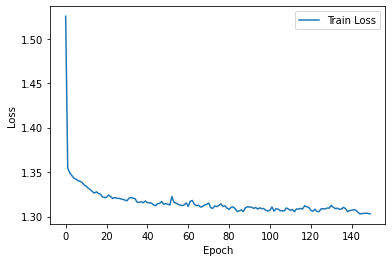


Saving the plot at  ..\..\data\loss\proxy_units__gru_training_loss_e_150_l_0.01_20210505_170255.png
RNNModule(
  (embedding): Embedding(123, 48)
  (gru): GRU(48, 48, batch_first=True)
  (dense): Linear(in_features=48, out_features=123, bias=True)
)


In [14]:
main()